# Capstone Project - The Battle of the Neighborhoods (Week 1& Week 2)


## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology and Results](#methodology)
* [Discussion](#results)
* [Conclusion](#conclusion)

*Somehow on GitHub the maps are hidden, so I upload a pdf file for review. Here is a link to the original ipynb file.

## Introduction: Business Problem <a name="introduction"></a>


In this project, I will try to find the patterns of the venues around top universities in America. This report will be targeted to stakeholders interested in investing new facilities (restaurants, gyms, etc.) around top universities.
I will try to answer following questions: what kinds of venues are the most popular around those universities, what’s the most common patterns of the venues around top universities, which universities’ surrounding venues are different from others (for example, have fewer restaurants than the majority). Those outliers (universities with different pattern of venues) might suggest gaps in the local market, which could help those stakeholders to make a wiser business decision. By fulfilling those gaps, they may make profits and develop connection with excellent university students and faculties.


## Data <a name="data"></a>


Based on the questions, I will need the datasets of:
* the names of those universities
* those universities' locations (longitudes and latitudes)
* the venues around those universities

First, I will choose the top 50 universities in American from [The Times Higher Education World University Rankings](https://www.timeshighereducation.com/world-university-rankings/2020/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/stats), and retrieve their location (longitudes & latitudes) applying **geocoder** package. Then, I will extract the venues around them using **Foursquare API**.



## Methodology and Results <a name="methodology"></a>


Let's import the necessary packages first.

In [814]:
import folium
import geocoder
import pandas as pd
import numpy as np

I simply copy and paste the names of those universities from the [webpage](https://www.timeshighereducation.com/world-university-rankings/2020/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/stats) into an excel file.

In [76]:
Uni=pd.read_excel('raw_data1.xlsx')
Uni=Uni[['Name']]
Uni['Latitude']=None
Uni['Longitude']=None
print(Uni.shape)
Uni.head()

(50, 3)


,Name,Latitude,Longitude
0,California Institute of Technology,None,None
1,Stanford University,None,None
2,Massachusetts Institute of Technology,None,None
3,Princeton University,None,None
4,Harvard University,None,None


Let's retrieve their location (longitudes & latitudes) applying **geocoder** package.

In [87]:
for i in range(Uni.shape[0]):
    g = geocoder.arcgis(str(Uni.iloc[i,0]))
    Uni.iloc[i,1]=g.latlng[0]
    Uni.iloc[i,2]=g.latlng[1]
Uni.head()

,Name,Latitude,Longitude
0,California Institute of Technology,34.1359,-118.127
1,Stanford University,37.4296,-122.165
2,Massachusetts Institute of Technology,42.359,-71.0935
3,Princeton University,40.3495,-74.6601
4,Harvard University,42.3759,-71.1234


Let's see their locations.

In [815]:
Latitude_avg=Uni['Latitude'].mean()
Longitude_avg=Uni['Longitude'].mean()
# create map using latitude and longitude values

map1 = folium.Map(location=[Latitude_avg, Longitude_avg], zoom_start=4)

# add markers to map
for lat, lng, name in zip(Uni['Latitude'], Uni['Longitude'], Uni['Name']):
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map1)   
map1 #somehow this map won't display in Github webpage. You may download this file and the raw_data1.xlsx then run the code.

In [97]:
import requests
CLIENT_ID = '4N2OKUVXD1N1RQYQJOCBRGF1GBGOML5KLC4WV1GNX0JH3U3S' 
CLIENT_SECRET = 'YZSH4L5VMESUMFUXNAP3AIZ10HZPZMKLV05QRGKA40I3JCVX' 
VERSION = '20180605'

Let's define a function to get the venues around them.

In [411]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,limit=50):  
    venues_list=[]
    for name, l1, l2 in zip(names, latitudes, longitudes): 
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            l1, 
            l2, 
            radius, 
            limit)            
        # make the GET request
        results=requests.get(url).json()["response"]['groups'][0]['items']
        for item in results:
            venues_list.append([(
            name, 
            l1, 
            l2, 
            item['venue']['name'], 
            item['venue']['location']['lat'], 
            item['venue']['location']['lng'],  
            item['venue']['categories'][0]['name'])])

    nearby_venues=pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns=['Name', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [412]:
venues_df1=getNearbyVenues(names=Uni['Name'],
                                   latitudes=Uni['Latitude'],
                                   longitudes=Uni['Longitude']
                                  )

California Institute of Technology
Stanford University
Massachusetts Institute of Technology
Princeton University
Harvard University
Yale University
University of Chicago
University of Pennsylvania
Johns Hopkins University
University of California, Berkeley
Columbia University
University of California, Los Angeles
Cornell University
Duke University
University of Michigan-Ann Arbor
Northwestern University
University of Washington
Carnegie Mellon University
New York University
University of California, San Diego
Georgia Institute of Technology
University of Texas at Austin
University of Illinois at Urbana-Champaign
University of Wisconsin-Madison
Washington University in St Louis
Brown University
University of North Carolina at Chapel Hill
University of California, Davis
University of California, Santa Barbara
Boston University
University of Southern California
Ohio State University (Main campus)
Penn State (Main campus)
University of Minnesota
Emory University
Michigan State University


In [746]:
print(venues_df1.shape)

(2265, 7)


The API failed to collect 50 venues for each university.
Let's choose those universities with enough records.

In [425]:
temp_list=venues_df1.groupby('Name').count().reset_index()
temp_list1=temp_list[temp_list['Venue']==50].iloc[:,0]
venues_df=venues_df1[venues_df1['Name'].isin(temp_list1.tolist())]

In [745]:
venues_df.head()

,Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,California Institute of Technology,34.1359,-118.12653,Turtle Pond at Caltech,34.136934,-118.125076,Lake
1,California Institute of Technology,34.1359,-118.12653,Braun Athletic Center,34.133974,-118.127581,Gym / Fitness Center
2,California Institute of Technology,34.1359,-118.12653,Athenaeum - Caltech,34.136842,-118.121675,Restaurant
3,California Institute of Technology,34.1359,-118.12653,Red Door Café,34.137354,-118.123820,Coffee Shop
4,California Institute of Technology,34.1359,-118.12653,Magnolia House,34.137525,-118.132207,Cocktail Bar


Let's use the column 'Venue Category' to conduct one-hot encoding

In [427]:
uni_onehot=pd.get_dummies(venues_df[['Venue Category']], prefix="", prefix_sep="")

In [428]:
uni_onehot['Name']=venues_df['Name']
uni_onehot['Latitude']=venues_df['Latitude']
uni_onehot['Longitude']=venues_df['Longitude']

In [429]:
uni_onehot.set_index('Name',inplace=True)
uni_onehot.reset_index(inplace=True)

In [430]:
uni_onehot.head()

,Name,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Latitude,Longitude
0,California Institute of Technology,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,34.1359,-118.12653
1,California Institute of Technology,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,34.1359,-118.12653
2,California Institute of Technology,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,34.1359,-118.12653
3,California Institute of Technology,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,34.1359,-118.12653
4,California Institute of Technology,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,34.1359,-118.12653


In [431]:
uni_grouped=uni_onehot.groupby('Name').sum().reset_index()
uni_grouped1=uni_onehot.groupby('Name').mean().reset_index()
uni_grouped[['Longitude','Latitude']]=uni_grouped1[['Longitude','Latitude']]

In [432]:
print(uni_grouped.shape)
uni_grouped.head()

(40, 270)


,Name,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Latitude,Longitude
0,Boston University,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,42.35021,-71.09887
1,Brown University,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,41.82751,-71.40477
2,California Institute of Technology,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,34.13590,-118.12653
3,Carnegie Mellon University,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,40.44401,-79.93919
4,Case Western Reserve University,0,0,1,0,0,0,0,1,2,...,0,0,0,0,0,1,0,0,41.50591,-81.60909


In [433]:
uni_grouped.describe()

,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Latitude,Longitude
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.050000,0.075000,1.750000,0.050000,0.150000,0.050000,0.025000,0.225000,0.625000,0.050000,...,0.025000,0.050000,0.150000,0.100000,0.075000,0.275000,0.025000,0.400000,39.202477,-90.292858
std,0.316228,0.266747,1.235168,0.220721,0.662164,0.220721,0.158114,0.479717,0.667467,0.220721,...,0.158114,0.220721,0.426675,0.303822,0.266747,0.505736,0.158114,2.372924,3.990632,17.556108
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.719030,-122.312090
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.759518,-99.616047
50%,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.229300,-85.642645
75%,0.000000,0.000000,2.250000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,41.990528,-76.584120
max,2.000000,1.000000,4.000000,1.000000,4.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,15.000000,47.656510,-71.093500


We can see that there are altogether 267 features (different venues' categories).

Since many of the categories only ouucr once or twice, I decide to apply **Principal Component Analysis(PCA)** to reduce the dimension.

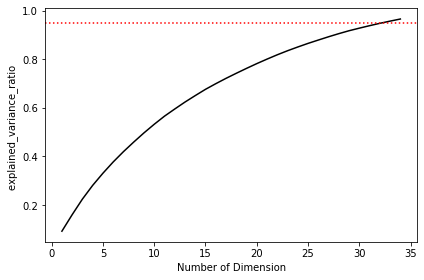

In [747]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
X=uni_grouped.iloc[:,1:-3]
Ks=35
explained_variance_ratio=pd.DataFrame({'dimension':(range(1,Ks)), 'explained_variance_ratio':None})
for i in range(1,Ks):   
    pca=PCA(n_components=i)
    pca.fit(X)    
    explained_variance_ratio.iloc[i-1,1]=pca.explained_variance_ratio_.sum()
plt.plot(range(1,Ks),explained_variance_ratio['explained_variance_ratio'],'black')
plt.axhline(y=0.95,ls=":",c="r")
plt.ylabel('explained_variance_ratio ')
plt.xlabel('Number of Dimension')
plt.tight_layout()
plt.show()

By observing the curve,we could reduce the dimension to 30, and still retain 95% variance of the data.


In [441]:
pca=PCA(n_components=30)
pca.fit(X)
new_X = pca.transform(X)
columns_names=[]
for i in range(30):
    columns_names.append('feature{0}'.format(str(i+1)))
new_X=pd.DataFrame(new_X,columns=columns_names)
new_X[['Name','Latitude','Longitude']]=uni_grouped[['Name','Latitude','Longitude']]

In [782]:
new_X.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature25,feature26,feature27,feature28,feature29,feature30,Name,Latitude,Longitude,Label
0,3.977102,-0.049702,0.000576,-1.526005,-1.690378,-2.797094,1.249293,-1.572034,-0.710321,-0.182765,...,-0.960290,-0.407445,-1.053043,1.064817,-1.724113,1.360279,Boston University,42.35021,-71.09887,0
1,-0.223479,-1.711022,1.420518,0.095976,-0.487588,0.106445,-0.852507,1.085062,0.418982,-0.088808,...,-0.295830,1.097795,-1.137198,-1.037241,-0.322727,-0.793531,Brown University,41.82751,-71.40477,0
2,0.887092,-0.874108,-0.802247,0.879089,-1.226281,-1.988652,1.471622,3.544906,-1.103013,3.418117,...,0.256010,-0.667978,-0.477362,0.245824,-0.091918,0.246526,California Institute of Technology,34.13590,-118.12653,0
3,0.823624,1.748895,0.618040,1.849034,1.832076,0.805689,1.090392,1.568253,-0.401426,-0.711812,...,-0.159111,-1.299971,0.404181,0.208739,-0.309552,1.028608,Carnegie Mellon University,40.44401,-79.93919,0
4,-0.339242,0.124315,1.451176,3.114980,4.787543,-0.640564,0.559536,-2.694808,1.097310,-0.867908,...,-0.652721,0.594298,0.028834,-0.482816,0.792996,1.382928,Case Western Reserve University,41.50591,-81.60909,1


Now, let's apply **K-Means** to classify those universities into several groups, by their surrounding venues' categories.

In [862]:
from sklearn.cluster import KMeans
#divide those universities into 3 groups, accoring to their surrounding venues.
a=new_X
n=3
k_means = KMeans(init = "k-means++", n_clusters = n, n_init = 12)
k_means.fit(a.iloc[:,0:-4])
k_means_labels = k_means.labels_
a['Label']=k_means_labels
color_list=['purple','red','orange']
map1 = folium.Map(location=[Latitude_avg, Longitude_avg], zoom_start=4)
# visualize the results, and add markers to map
for lat, lng, name,color_label in zip(a['Latitude'], a['Longitude'], a['Name'],a['Label']):
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=color_list[color_label],
        fill=True,
        fill_opacity=0.4,
        parse_html=False).add_to(map1)   
display(map1)

We can see that 20 universities were assigned to **group 1** and 19 universities were assigned to **group 2**, which were very close in value.
While the remaining 1 university might have different pattens of venues around it, and seem to be an outlier.
By observing the map, we can infer that geographical locations have little to do with the venues' patterns, as different groups are mixed in the map.

In [864]:
a['Label'].value_counts()

1    20
2    19
0     1
Name: Label, dtype: int64

Let's summarize and find the differences between the two main groups and analyze those outliers.

In [865]:
a[a['Label']==0][['Name']] #find the outlier

,Name
5,Columbia University


In [866]:
#add the group label to the dataframe
uni_grouped_index=a[['Name','Label']] 
uni_final=pd.merge(uni_grouped, uni_grouped_index, how='left')

In [867]:
uni_final.head()

,Name,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Latitude,Longitude,Label
0,Boston University,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,42.35021,-71.09887,2
1,Brown University,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,41.82751,-71.40477,1
2,California Institute of Technology,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,34.13590,-118.12653,2
3,Carnegie Mellon University,0,0,1,0,0,0,0,0,1,...,0,0,0,1,1,0,0,40.44401,-79.93919,2
4,Case Western Reserve University,0,0,1,0,0,0,0,1,2,...,0,0,0,0,1,0,0,41.50591,-81.60909,1


In [868]:
uni_group1=uni_final[uni_final['Label']==1]
uni_group2=uni_final[uni_final['Label']==2]
uni_outlier=uni_final[uni_final['Label']==0]

In [869]:
# combine the universities in the same group
a=uni_final.groupby('Label').mean()

In [870]:
a.reset_index(inplace=True)
a.head()

,Label,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Latitude,Longitude
0,0,0.000000,0.000000,3.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,1.0,0.0,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,40.808160,-73.96365
1,1,0.000000,0.100000,1.500000,0.050000,0.050000,0.1,0.000000,0.250000,0.650000,...,0.0,0.1,0.25,0.150000,0.050000,0.400000,0.000000,0.000000,39.763555,-93.55817
2,2,0.105263,0.052632,1.947368,0.052632,0.263158,0.0,0.052632,0.210526,0.631579,...,0.0,0.0,0.00,0.052632,0.105263,0.157895,0.052632,0.842105,38.527359,-87.71512


We would only need the information of venues' categories to further analysis, so let's drop the Latitude and Longitude columns.

In [871]:
a=a.iloc[:,0:-2]

In [872]:
a

,Label,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,...,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,0.000000,0.000000,3.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,0.0,1.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.000000,0.100000,1.500000,0.050000,0.050000,0.1,0.000000,0.250000,0.650000,...,0.200000,0.000000,0.0,0.1,0.25,0.150000,0.050000,0.400000,0.000000,0.000000
2,2,0.105263,0.052632,1.947368,0.052632,0.263158,0.0,0.052632,0.210526,0.631579,...,0.052632,0.052632,0.0,0.0,0.00,0.052632,0.105263,0.157895,0.052632,0.842105


In [873]:
# sort the dataframe, to get the frequency of each venues for each group
feature_1=pd.DataFrame({'avg_number':a.iloc[1,1:]}).sort_values(by='avg_number',ascending=False)
feature_2=pd.DataFrame({'avg_number':a.iloc[2,1:]}).sort_values(by='avg_number',ascending=False)
feature_0=pd.DataFrame({'avg_number':a.iloc[0,1:]}).sort_values(by='avg_number',ascending=False)

Let's see the most popular kinds of venues in the two main groups.

In [875]:
feature_1.head(15)

,avg_number
Coffee Shop,4.25
Sandwich Place,2.35
Pizza Place,1.80
American Restaurant,1.50
Café,1.20
Ice Cream Shop,1.05
Bar,0.95
Mexican Restaurant,0.85
Bakery,0.85
Park,0.80


In [876]:
feature_2.head(15)

,avg_number
Coffee Shop,2.105263
American Restaurant,1.947368
Pizza Place,1.736842
Café,1.631579
Hotel,1.578947
Indian Restaurant,1.052632
Italian Restaurant,1.000000
Sandwich Place,0.947368
Japanese Restaurant,0.894737
Mexican Restaurant,0.842105


We can see that in both groups, most common venues are about catering, like coffee shop and different kinds of restaurants.

Let's further compare those two groups, finding their biggest differences.

In [877]:
delta_1_2=pd.DataFrame({'delta_1_2':a.iloc[1,1:]-a.iloc[2,1:],'abs(delta_1_2)':abs(a.iloc[1,1:]-a.iloc[2,1:])}).sort_values(by='abs(delta_1_2)',ascending=False)
delta_0_2=pd.DataFrame({'delta_0_2':a.iloc[0,1:]-a.iloc[2,1:],'abs(delta_0_2)':abs(a.iloc[0,1:]-a.iloc[2,1:])}).sort_values(by='abs(delta_0_2)',ascending=False)
delta_0_1=pd.DataFrame({'delta_0_1':a.iloc[0,1:]-a.iloc[1,1:],'abs(delta_0_1)':abs(a.iloc[0,1:]-a.iloc[1,1:])}).sort_values(by='abs(delta_0_1)',ascending=False)

In the following table, the index is the category of venues, column 1 refers to the average number of a certain category around a university in **group 0** minus that number of a university in **group 1**.

In [880]:
delta_1_2.head(15)

,delta_1_2,abs(delta_1_2)
Coffee Shop,2.144737,2.144737
Sandwich Place,1.402632,1.402632
Hotel,-0.978947,0.978947
Japanese Restaurant,-0.844737,0.844737
Zoo Exhibit,-0.842105,0.842105
Indian Restaurant,-0.752632,0.752632
Sushi Restaurant,-0.639474,0.639474
Food Truck,-0.486842,0.486842
American Restaurant,-0.447368,0.447368
Asian Restaurant,0.442105,0.442105


From the above table, we can see that it is mainly the structure of the local catering industry that differ those two main groups.

For example, **group 1** has more Coffee Shops and Sandwich Places around it, while **group 2** has more Japanese Restaurants and Indian Restaurants around it.

Apart from the differences in catering industry, **group 2** also has more Hotels, Zoo Exhibits and Performing Arts Venues around it.

Then, let's figure out what makes **group 0** (outlier,*Columbia University*) different from the two main groups.

In [882]:
delta_0_1.head(15)

,delta_0_1,abs(delta_0_1)
Park,4.20,4.20
Bookstore,2.40,2.40
Italian Restaurant,2.25,2.25
Playground,2.00,2.00
Farmers Market,1.80,1.80
Pizza Place,-1.80,1.80
Food Truck,1.75,1.75
Seafood Restaurant,1.70,1.70
Grocery Store,1.65,1.65
American Restaurant,1.50,1.50


In [883]:
delta_0_2.head(15)

,delta_0_2,abs(delta_0_2)
Park,4.526316,4.526316
Bookstore,2.263158,2.263158
Italian Restaurant,2.000000,2.000000
Farmers Market,1.894737,1.894737
Playground,1.842105,1.842105
Seafood Restaurant,1.842105,1.842105
Pizza Place,-1.736842,1.736842
Grocery Store,1.631579,1.631579
Hotel,-1.578947,1.578947
Food Truck,1.263158,1.263158


From the above tables, we can see that compared with two main groups, **group 0**(outlier, *Columbia University* ) has more Parks, Bookstores, Italian Restaurants etc. Besides, compared with **group 1**, **group 0** has fewer <font color=red> Pizza Places </font> and Coffee Shops; compared with **group 2**, **group 0** has fewer <font color=red> Pizza Places </font>, Hotels and India Restaurants. So, considering the potential gaps in the market, I suggest the stakeholders invest new Pizza Places around *Columbia University* .

## Discussion <a name="results"></a>

Based on the analysis and results, I suggest the stakeholders invest new **Pizza Places** around *Columbia University*. 
However, there are several potential limitations in the analysis:
* I did not consider the population density around those universities. Higher density implies that there should be more venues to fulfill their need.
* I did not consider the local people’ nationalities. For example, if there are many Chinese students in a certain university, to invest a Chinese restaurant nearby could be a wise choice.
* I couldn’t find a way to create proper weight factors to different venues. Since many of the venues are in the catering industry, other venues’ importance could be shadowed.
If you have any suggestions or comments, please feel free to leave me a note.


## Conclusion <a name="conclusion"></a>

* There are generally two different patterns of venues around top universities in America.
* The two patterns are mainly differed by the structure of the local catering industry.
* *Columbia University* has different venues’ pattern. To invest new **Pizza Places** around them might fulfill the potential gaps in local market, thus helping the stakeholders to make profits and develop connection with excellent university students and faculties.